In [1]:
import numpy as np
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')

# 데이터 불러오기
file_path = '/content/drive/MyDrive/Colab Notebooks/final_nba_data_2.csv'
data = pd.read_csv(file_path, encoding='latin1')


# 결측치가 있는 모든 행 제거
data_cleaned = data.dropna()

# Pos 열의 값이 특정 값인 행 제거
positions_to_remove = ['C-PF', 'PF-SF', 'PG-SG', 'SF-SG', 'SG-PG', 'SG-SF']
data_filtered = data_cleaned[~data_cleaned['Pos'].isin(positions_to_remove)]
data_filtered = data_filtered.drop(columns=['Pos'])
# 원-핫 인코딩된 열만 선택하여 int로 변환
encoded_columns = [col for col in data_filtered.columns if col.startswith('Pos_')]
data_filtered[encoded_columns] = data_filtered[encoded_columns].astype(int)
data_encoded = data_filtered

# target feature (목표 변수)
target = data_encoded['target']
# input feature (입력 변수들)
input_features = data_encoded.drop(columns=['name', 'target', 'salary'])

data_encoded = data_filtered
# target feature (목표 변수)
target = data_encoded['target']
# input feature (입력 변수들)
input_features = data_encoded.drop(columns=['name', 'target', 'salary'])
# 결과 데이터 확인
input_features.info()

Mounted at /content/drive
<class 'pandas.core.frame.DataFrame'>
Index: 1551 entries, 0 to 1575
Data columns (total 36 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   start            1551 non-null   int64  
 1   GS               1551 non-null   float64
 2   MP               1551 non-null   float64
 3   FG               1551 non-null   float64
 4   FGA              1551 non-null   float64
 5   FG%              1551 non-null   float64
 6   3P               1551 non-null   float64
 7   3PA              1551 non-null   float64
 8   3P%              1551 non-null   float64
 9   2P               1551 non-null   float64
 10  2PA              1551 non-null   float64
 11  2P%              1551 non-null   float64
 12  eFG%             1551 non-null   float64
 13  FT               1551 non-null   float64
 14  FTA              1551 non-null   float64
 15  FT%              1551 non-null   float64
 16  ORB              1551 non-null   float6

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
# 데이터셋을 학습용과 테스트용으로 분리
X_train, X_test, y_train, y_test = train_test_split(input_features, target, test_size=0.3, random_state=42)

# 표준화 제외할 feature들
exclude_cols = ['Pos_PG', 'Pos_SG', 'Pos_SF', 'Pos_PF', 'Pos_C']

# 표준화 할 feature들
cols_to_scale = [col for col in X_train.columns if col not in exclude_cols]

# 표준화
scaler = StandardScaler()
scaler.fit(X_train[cols_to_scale])
X_train[cols_to_scale] = scaler.transform(X_train[cols_to_scale])
X_test[cols_to_scale] = scaler.transform(X_test[cols_to_scale])

X_train.head()

,start,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,...,end,birth,G,Pos_PG,Pos_SG,Pos_SF,Pos_PF,Pos_C,contract_period,Annual
1437,0.980286,-0.928034,-1.116717,-0.946841,-0.841904,-0.907514,-0.496713,-0.285231,-0.441503,-0.905921,...,0.971815,0.125567,-0.887800,1,0,0,0,0,0.027299,-1.020332
314,1.304262,-0.928034,-2.127033,-1.492334,-1.451407,-4.911889,-1.070320,-0.924339,-2.172157,-1.302080,...,0.971815,0.191567,-1.475170,0,1,0,0,0,-0.795463,-1.020332
1000,-0.315615,-0.768234,-1.293940,-1.069577,-1.136497,0.145529,-0.430687,-0.478561,0.688691,-1.135371,...,-0.616644,0.059567,-1.211866,0,0,0,0,1,-0.795463,-0.779824
640,0.332336,-0.079864,-0.319689,-0.343303,-0.688356,2.012715,-1.070320,-1.171993,-2.172157,0.057246,...,0.654123,0.092567,-0.058939,1,0,0,0,0,0.850061,-0.539315
111,-0.639590,0.679258,0.045938,-0.107906,-0.035533,-0.230804,0.269439,0.188761,0.617037,-0.246252,...,-0.616644,0.059567,-0.205440,0,0,0,1,0,0.027299,-0.539315


In [3]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score

xgb = XGBRegressor(random_state=42)
ada = AdaBoostRegressor(random_state=42)

# Minimized parameter grids for quick execution
param_grid_xgb_minimized = {
    'n_estimators': [100,150,200],
    'learning_rate': [0.001,0.01,0,1],
    'max_depth': [3,4,5]
}
param_grid_ada_minimized = {
    'n_estimators': [50,100,150],
    'learning_rate': [0.001,0.01,0.1]
}

# Define the grid search with minimized parameter grid
grid_search_xgb_minimized = GridSearchCV(estimator=xgb, param_grid=param_grid_xgb_minimized, scoring='r2', cv=5)
grid_search_ada_minimized = GridSearchCV(estimator=ada, param_grid=param_grid_ada_minimized, scoring='r2', cv=5)

# Perform the grid search with minimized parameter grid
grid_search_xgb_minimized.fit(X_train, y_train)
grid_search_ada_minimized.fit(X_train, y_train)

# Get the best models
best_xgb_minimized = grid_search_xgb_minimized.best_estimator_
best_ada_minimized = grid_search_ada_minimized.best_estimator_

# Evaluate the models on the test set
y_pred_xgb_minimized = best_xgb_minimized.predict(X_test)
y_pred_ada_minimized = best_ada_minimized.predict(X_test)

In [4]:
best_params_xgb = grid_search_xgb_minimized.best_params_
best_params_ada = grid_search_ada_minimized.best_params_

print("Best parameters for XGBoost: ", best_params_xgb)
print("Best parameters for AdaBoost: ", best_params_ada)


Best parameters for XGBoost:  {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 200}
Best parameters for AdaBoost:  {'learning_rate': 0.1, 'n_estimators': 100}


In [5]:
xgb_train_r2 = r2_score(y_train, best_xgb_minimized.predict(X_train))
xgb_test_r2 = r2_score(y_test, y_pred_xgb_minimized)

ada_train_r2 = r2_score(y_train, best_ada_minimized.predict(X_train))
ada_test_r2 = r2_score(y_test, y_pred_ada_minimized)

print(f"XGBoost Train r2: {xgb_train_r2}")
print(f"XGBoost Test r2: {xgb_test_r2}")
print(f"ADABoost Train r2: {ada_train_r2}")
print(f"ADABoost Test r2: {ada_test_r2}")

XGBoost Train r2: 0.8877333718642045
XGBoost Test r2: 0.7544788517260079
ADABoost Train r2: 0.8447871935456448
ADABoost Test r2: 0.7234222676654674


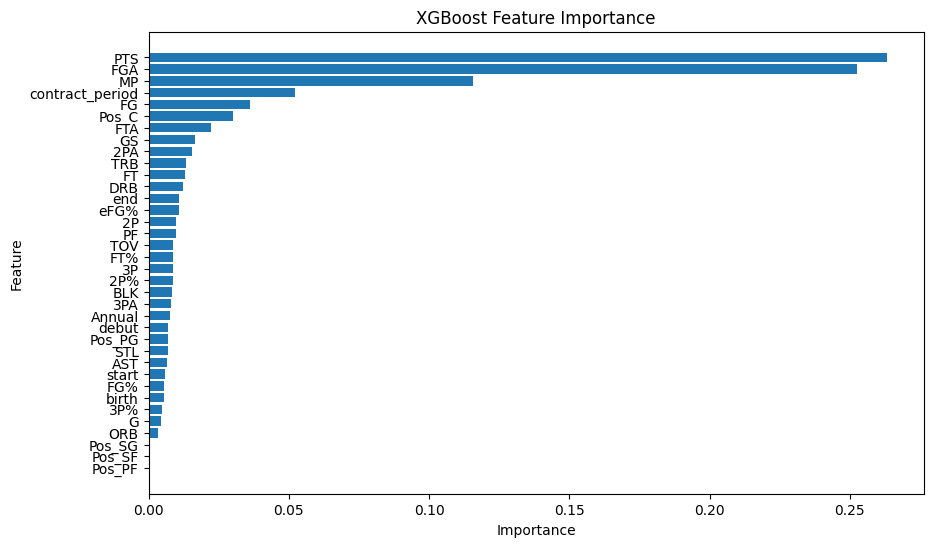

In [7]:
import matplotlib.pyplot as plt
from sklearn.tree import export_graphviz
from IPython.display import display
import graphviz
import xgboost as xgb
from xgboost import plot_importance, plot_tree

feature_names = X_train.columns if hasattr(X_train, 'columns') else [f'feature_{i}' for i in range(X_train.shape[1])]
feature_importances = best_xgb_minimized.feature_importances_
features_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
features_df = features_df.sort_values(by='Importance', ascending=False)


plt.figure(figsize=(10, 6))
plt.barh(features_df['Feature'], features_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('XGBoost Feature Importance')
plt.gca().invert_yaxis()  # Invert y axis to have the most important feature on top
plt.show()

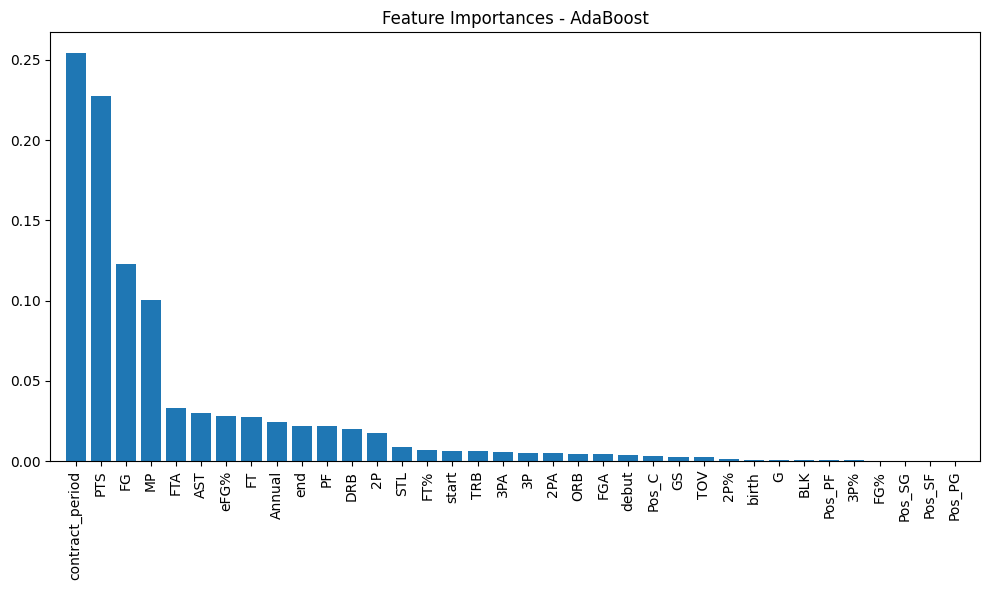

In [8]:
# Feature importance 추출
importances = best_ada_minimized.feature_importances_
indices = np.argsort(importances)[::-1]
features = input_features.columns

# 시각화
plt.figure(figsize=(10, 6))
plt.title("Feature Importances - AdaBoost")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), features[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

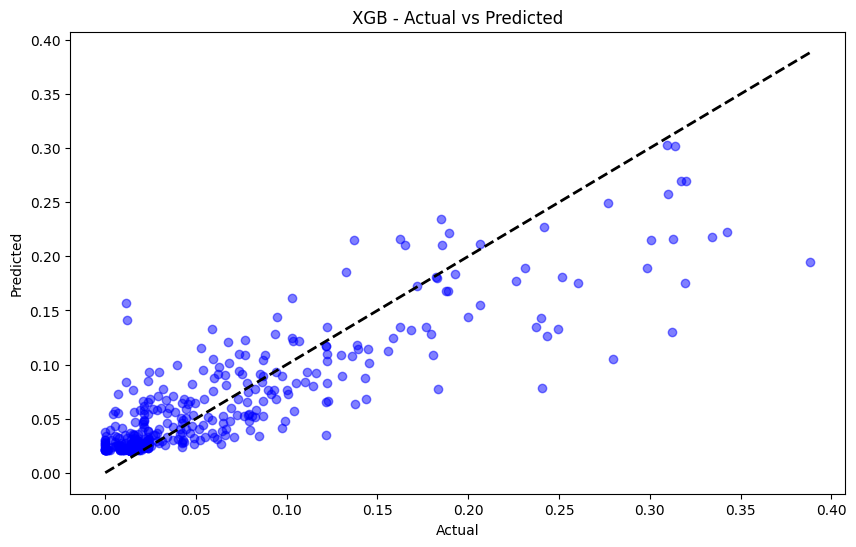

In [9]:
 # 예측 결과 시각화
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_xgb_minimized, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('XGB - Actual vs Predicted')
plt.show()

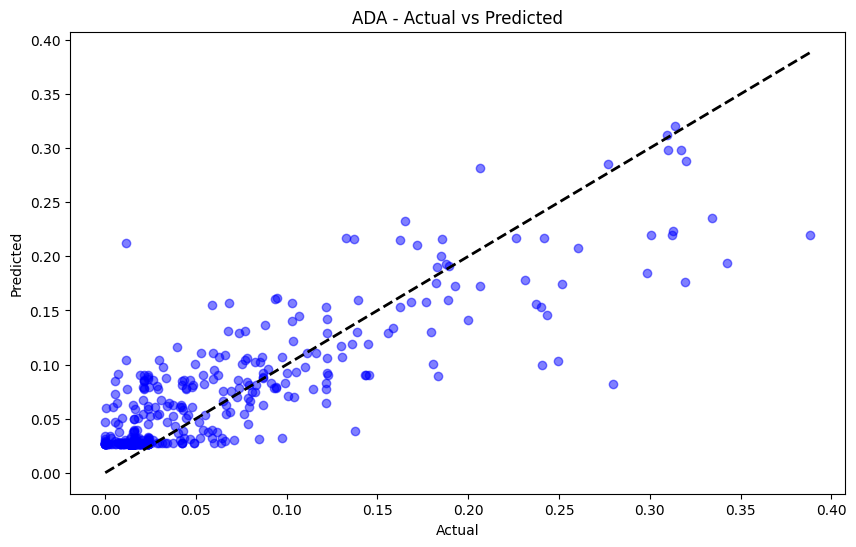

In [10]:
# 예측 결과 시각화
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_ada_minimized, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('ADA - Actual vs Predicted')
plt.show()